In [18]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [19]:
DEV = True

In [20]:
embedding_model_name = 'dunzhang/stella_en_400M_v5'
embedding_model_name = "avsolatorio/GIST-Embedding-v0"

In [21]:
print(f'Loading model {embedding_model_name}...')

if DEV:
    train_data = pd.read_json(f'embeddings/{embedding_model_name}/dev/train_embeddings.json', orient='records')
    test_data = pd.read_json(f'embeddings/{embedding_model_name}/dev/test_embeddings.json', orient='records')
else:
    train_data = pd.read_json(f'embeddings/{embedding_model_name}/train_embeddings.json', orient='records')
    test_data = pd.read_json(f'embeddings/{embedding_model_name}/test_embeddings.json', orient='records')


train_data.info()
train_data.head()

Loading model avsolatorio/GIST-Embedding-v0...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   chunk_id    10000 non-null  int64 
 1   url         9191 non-null   object
 2   text        10000 non-null  object
 3   class       10000 non-null  object
 4   relevance   10000 non-null  object
 5   embeddings  10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


,chunk_id,url,text,class,relevance,embeddings
0,9354,https://www.defensedaily.com/wp-content/upload...,ask force found that a minor modified LCS (of ...,irrelevant,irrelevant,"[-0.0026561695, -0.0181116443, -0.018887395, 0..."
1,7587,https://dcwltd.com/wp-content/uploads/2023/11/...,HELKE '1203320068837332 2 Equity share NAINA C...,irrelevant,irrelevant,"[0.011645609500000001, -0.026258425800000002, ..."
2,7587,https://dcwltd.com/wp-content/uploads/2023/11/...,97413193131 8196 Equity share KAMLESHBHAI GORE...,irrelevant,irrelevant,"[-0.0142423259, -0.017405754000000002, -0.0213..."
3,7370,PDF-PLACEHOLDER,"erflies. Journal \nof Insect Conservation, 15,...",..,relevant,"[0.0079465974, -0.030159454800000002, -0.01160..."
4,9343,https://deercreekflorida.com/wp-content/upload...,or: Boca By Design 561-447-5444 Photobooth: Da...,irrelevant,irrelevant,"[0.0083078193, 0.008548152600000001, 0.0175007..."


In [22]:
yLabels = train_data['relevance'].tolist()
xFeatures = train_data['embeddings'].tolist()

In [23]:
import pickle

def save_model(classifier, model_name):
    pickle.dump(classifier, open(f'models/{model_name}.pkl', "wb"),protocol=5)
    print(f"{model_name} saved to disk")

In [24]:
# logistic regression
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=1000)

In [25]:
# random forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()


In [26]:
# naive bayes

from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()


In [27]:
# nearest neigbours
from sklearn.neighbors import KNeighborsClassifier

neighbours = KNeighborsClassifier()



In [28]:
# rbf svm
from sklearn.svm import SVC

svm = SVC(kernel='rbf')


In [29]:
# nn
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier()


In [30]:
classifiers = [forest, logistic , bayes, neighbours, svm, nn]


In [31]:
import time

for classifier in classifiers:

    print(f"Training {classifier.__class__.__name__}...")
    start = time.time()
    classifier.fit(xFeatures, yLabels)
    end = time.time()
    print("Training Complete. Saving to disk...", end="\r")
    save_model(classifier, classifier.__class__.__name__)
    print(f"Training {classifier.__class__.__name__} complete in {round(end-start, 4)} seconds. Saved to disk.\n")


Training RandomForestClassifier...
RandomForestClassifier saved to disk
Training RandomForestClassifier complete in 51.2842 seconds. Saved to disk.

Training LogisticRegression...
LogisticRegression saved to diskk...
Training LogisticRegression complete in 0.7761 seconds. Saved to disk.

Training GaussianNB...
GaussianNB saved to diskg to disk...
Training GaussianNB complete in 0.9572 seconds. Saved to disk.

Training KNeighborsClassifier...
KNeighborsClassifier saved to disk..
Training KNeighborsClassifier complete in 0.7118 seconds. Saved to disk.

Training SVC...
SVC saved to disk. Saving to disk...
Training SVC complete in 11.3104 seconds. Saved to disk.

Training MLPClassifier...
MLPClassifier saved to disko disk...
Training MLPClassifier complete in 53.4399 seconds. Saved to disk.



In [32]:
testData = {
    'relevance':test_data['relevance'].tolist(),
    'embeddings':test_data['embeddings'].tolist()
}

# maximise function with high precision
def precision_accuracy(accu, prec,ratio=0.3):
    return ratio * accu + (1-ratio) * prec

In [33]:
results = {}

for classifier in classifiers:
    predYLabels = classifier.predict(testData["embeddings"])

    results[classifier.__class__.__name__] = {
        "accuracy": accuracy_score(testData['relevance'], predYLabels),
        "f1": f1_score(
            testData['relevance'], predYLabels, average="macro", zero_division=0
        ),
        "precision": precision_score(
            testData['relevance'], predYLabels, average="macro", zero_division=0
        ),
        "confusion_matrix": confusion_matrix(testData['relevance'], predYLabels,labels=['relevant','irrelevant']),
    }
    results[classifier.__class__.__name__]["precision-accuracy"] = precision_accuracy(
        results[classifier.__class__.__name__]["accuracy"],
        results[classifier.__class__.__name__]["precision"],
    )


def format_output(metrics):
    for classifier, metric in sorted(metrics.items(),key=lambda x: x[1]['precision-accuracy'],reverse=True):
        for key, value in metric.items():
            # truncate
            if key != "confusion_matrix":
                metric[key] = round(value, 6)
        print(
            f"Classifier: {classifier} \nAccuracy: {metric['accuracy']} \t F1: {metric['f1']} \t Precision: {metric['precision']} \t Precision-Accuracy: {metric['precision-accuracy']}"
        )
        print("\n\n")


format_output(results)

Classifier: LogisticRegression 
Accuracy: 0.9965 	 F1: 0.996279 	 Precision: 0.996408 	 Precision-Accuracy: 0.996436



Classifier: SVC 
Accuracy: 0.9965 	 F1: 0.996281 	 Precision: 0.996154 	 Precision-Accuracy: 0.996258



Classifier: KNeighborsClassifier 
Accuracy: 0.9965 	 F1: 0.996287 	 Precision: 0.995419 	 Precision-Accuracy: 0.995743



Classifier: RandomForestClassifier 
Accuracy: 0.994 	 F1: 0.99361 	 Precision: 0.994668 	 Precision-Accuracy: 0.994468



Classifier: MLPClassifier 
Accuracy: 0.9935 	 F1: 0.993076 	 Precision: 0.99427 	 Precision-Accuracy: 0.994039



Classifier: GaussianNB 
Accuracy: 0.991 	 F1: 0.990464 	 Precision: 0.989029 	 Precision-Accuracy: 0.98962





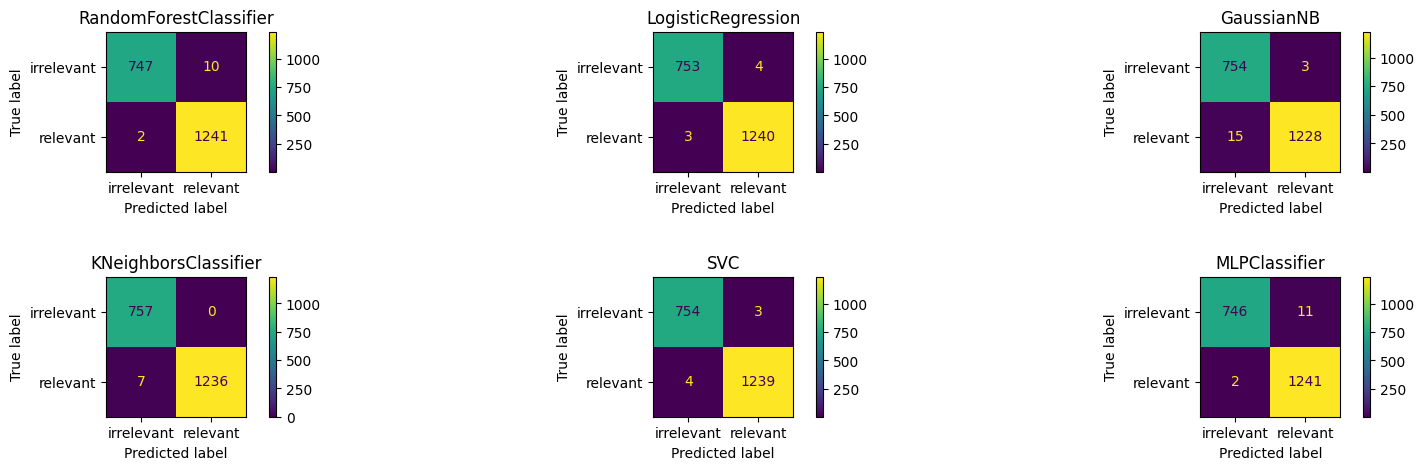

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


# display in len(classifiers) subplot squares

fig, axs = plt.subplots(2, int(len(classifiers)/2), figsize=(20, 5))
plt.subplots_adjust(hspace=0.75)


for i, classifier in enumerate(classifiers):
    confusion = results[classifier.__class__.__name__]["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=['irrelevant', 'relevant'])
    disp.plot(ax=axs[int(i/3), i % 3])
    # add title
    axs[int(i/3), i % 3].set_title(classifier.__class__.__name__)



plt.show()